# MISS meets TRAK

MISS for non-linear model: linearizing as TRAK

> The target function is assumed to be the raw logit, i.e., $\phi(x_{\text{test}}) = \theta^\top x_{\text{test}} + b$.

In [1]:

import os
os.environ["PYTHONWARNINGS"] = "ignore"

import sys
sys.path.append('../logistic_regression')

import numpy as np
from joblib import Parallel, delayed
import matplotlib.pyplot as plt

from actual import actual_effect
from IWLS import IWLS, adaptive_IWLS
from first_order import first_order, adaptive_first_order
from margin import margin

from target import target_value

In [2]:
ks = [1, 2, 5, 10]
targets = ["probability", "abs_probability", "test_loss", "abs_test_loss", "avg_abs_test_loss", "abs_avg_test_loss"]
methods = ["IWLS", "Adaptive IWLS", "Margin-based", "First-order", "Adaptive First-order"]

# enumerate all size 2 combination for 10 class
class_combo = [(i, j) for i in range(10) for j in range(i+1, 10)]

num_methods, num_experiments, num_ks = len(methods), len(class_combo), len(ks)

In [3]:
def data_generation(class1, class2, target="probability"):
    X = np.load('./trak_results/0/features.mmap')
    y = np.load('./trak_results/0/labels.npy')

    # Find unique labels
    unique_labels = np.unique(y)

    # Create a dictionary to hold subsets of data for each label
    data_by_label = {label: {'X': [], 'y': []} for label in unique_labels}

    # Iterate over each sample and its corresponding label
    for sample, label in zip(X, y):
        # Append the sample and its label to the corresponding subset
        data_by_label[label]['X'].append(sample)
        data_by_label[label]['y'].append(label)

    # Convert lists to arrays
    for label in unique_labels:
        data_by_label[label]['X'] = np.array(data_by_label[label]['X'])
        data_by_label[label]['y'] = np.array(data_by_label[label]['y'])

    # Define the classes you want to include
    classes_to_include = [class1, class2]

    # Find the indices of samples belonging to the specified classes
    indices_to_include = np.where(np.isin(y, classes_to_include))

    # Filter X and y based on the selected indices
    X = X[indices_to_include]
    y = y[indices_to_include]

    n = len(y)
    n_train = n // 2

    X_train = X[:n_train]
    y_train = y[:n_train]

    X_test_full = X[n_train:]
    y_test_full = y[n_train:]

    if target in ["probability", "abs_probability", "test_loss", "abs_test_loss"]: # only one test point
        random_index = np.random.choice(n_train)
        X_test = X_test_full[random_index].reshape(1, -1)
        y_test = y_test_full[random_index].reshape(1, -1)
    elif target in ["avg_abs_test_loss", "abs_avg_test_loss"]: # n test points
        X_test, y_test = X_test_full, y_test_full
    else: # no test point needed
        X_test = None
        y_test = None

    return X_train, y_train, X_test, y_test

In [4]:
def actual_effect_NN(X_train, y_train, X_test, y_test, subset_to_remove, original_value, target="probability"):
    reduced_X_train = np.delete(X_train, subset_to_remove, axis=0)
    reduced_y_train = np.delete(y_train, subset_to_remove, axis=0)
    reduced_value = target_value(reduced_X_train, reduced_y_train, X_test, y_test, target)

    if target == "avg_abs_test_loss":
        score = np.mean(np.abs(original_value - reduced_value))
    elif target in ["abs_probability", "abs_test_loss"]:
        score = np.abs(original_value - reduced_value)
    else:
        score = reduced_value - original_value

    return score

In [5]:
def score_per_class_combo(class1, class2, k, target):
    X_train, y_train, X_test, y_test = data_generation(class1, class2, target=target)
    original_value = target_value(X_train, y_train, X_test, y_test, target=target)

    ind_n, ind_p = margin(X_train, y_train)

    scores = np.array([
        actual_effect(X_train, y_train, X_test, y_test, IWLS(X_train, y_train, X_test, y_test, target=target)[:k], original_value, target=target),
        actual_effect(X_train, y_train, X_test, y_test, adaptive_IWLS(X_train, y_train, X_test, y_test, k=k, target=target), original_value, target=target),
        max(actual_effect(X_train, y_train, X_test, y_test, ind_n[:k], original_value, target=target), actual_effect(X_train, y_train, X_test, y_test, ind_p[:k], original_value, target=target)),
        actual_effect(X_train, y_train, X_test, y_test, first_order(X_train, y_train, X_test, y_test, target=target)[:k], original_value, target=target),
        actual_effect(X_train, y_train, X_test, y_test, adaptive_first_order(X_train, y_train, X_test, y_test, k=k, target=target), original_value, target=target)
    ])

    return scores

In [6]:
# ranks.shape = (num_methods, num_experiments)
def Borda_count(ranks, weights=[5, 4, 3, 2, 1]):
    num_methods, num_experiments = ranks.shape

    weighted_borda_count = np.zeros((num_methods, num_experiments), dtype=int)

    # Calculate weighted Borda count for each seed and covariance
    for experiment_idx in range(num_experiments):
        # Sort indices based on actual ranks for the current experiment
        # tie-handling. ref: https://stackoverflow.com/questions/39059371/can-numpys-argsort-give-equal-element-the-same-rank
        def rankmin(x):
            u, inv, counts = np.unique(x, return_inverse=True, return_counts=True)
            csum = np.zeros_like(counts)
            csum[1:] = counts[:-1].cumsum()
            return csum[inv]

        sorted_indices = rankmin(-1 * ranks[:, experiment_idx])

        # Assign weighted Borda count scores
        for method_idx, rank in enumerate(sorted_indices):
            weighted_borda_count[method_idx, experiment_idx] = weights[rank]

    total_weighted_borda_count = weighted_borda_count.sum(axis=1)

    return total_weighted_borda_count

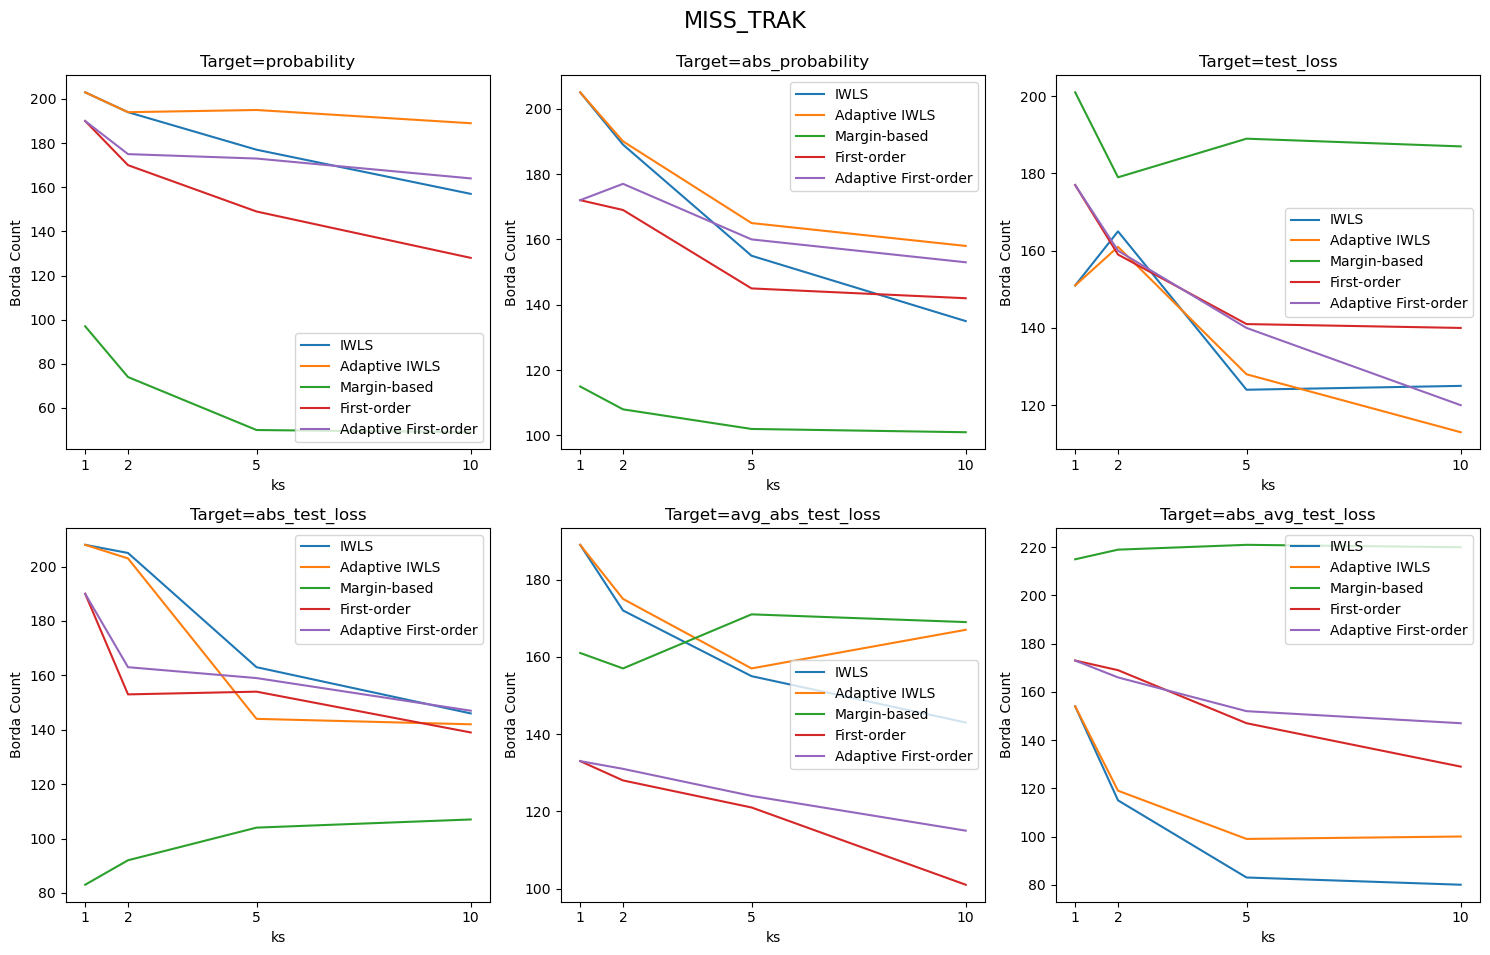

In [7]:
fig, axs = plt.subplots(2, 3, figsize=(15, 10))  # Create a 2x3 grid of subplots

for target_idx, target in enumerate(targets):
    scores_array = np.array(Parallel(n_jobs=20)(delayed(score_per_class_combo)(class1, class2, k, target) for class1, class2 in class_combo for k in ks))
    scores_array = scores_array.reshape((num_experiments, num_ks, -1))

    scores_method_ks_combo = scores_array.swapaxes(0, 2) # method, k, combo
    scores_ks_method_combo = scores_method_ks_combo.swapaxes(0, 1) # k, method, combo

    Borda_result = np.zeros((num_ks, num_methods), dtype=float)

    Borda_result = np.array(Parallel(n_jobs=20)(delayed(Borda_count)(scores_ks_method_combo[k_idx]) for k_idx in range(num_ks)))

    # Plot in the corresponding subplot
    row_idx, col_idx = divmod(target_idx, 3)  # Calculate subplot index
    for method_idx, method_name in enumerate(methods):
        axs[row_idx, col_idx].plot(ks, Borda_result[:, method_idx], label=method_name)

    axs[row_idx, col_idx].set_title(f'Target={target}')
    axs[row_idx, col_idx].set_xlabel('ks')
    axs[row_idx, col_idx].set_ylabel('Borda Count')
    axs[row_idx, col_idx].legend(methods)

    axs[row_idx, col_idx].set_xticks(ks)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.suptitle(f'MISS_TRAK', fontsize=16)

plt.show()

In [8]:
def ratio_per_combo_k(class1, class2, k, target):
    X_train, y_train, X_test, y_test = data_generation(class1, class2, target=target)

    original_value = target_value(X_train, y_train, X_test, y_test, target=target)

    ind_n, ind_p = margin(X_train, y_train)

    scores = np.array([
        actual_effect(X_train, y_train, X_test, y_test, IWLS(X_train, y_train, X_test, y_test, target=target)[:k], original_value, target=target),
        actual_effect(X_train, y_train, X_test, y_test, adaptive_IWLS(X_train, y_train, X_test, y_test, k=k, target=target), original_value, target=target),
        max(actual_effect(X_train, y_train, X_test, y_test, ind_n[:k], original_value, target=target), actual_effect(X_train, y_train, X_test, y_test, ind_p[:k], original_value, target=target)),
        actual_effect(X_train, y_train, X_test, y_test, first_order(X_train, y_train, X_test, y_test, target=target)[:k], original_value, target=target),
        actual_effect(X_train, y_train, X_test, y_test, adaptive_first_order(X_train, y_train, X_test, y_test, k=k, target=target), original_value, target=target)
    ])

    return np.array([
        scores[0] / scores[3],
        scores[1] / scores[3],
        scores[2] / scores[3],
        1,
        scores[4] / scores[3]
    ])

Target: probability
Target: abs_probability
Target: test_loss
Target: abs_test_loss
Target: avg_abs_test_loss
Target: abs_avg_test_loss


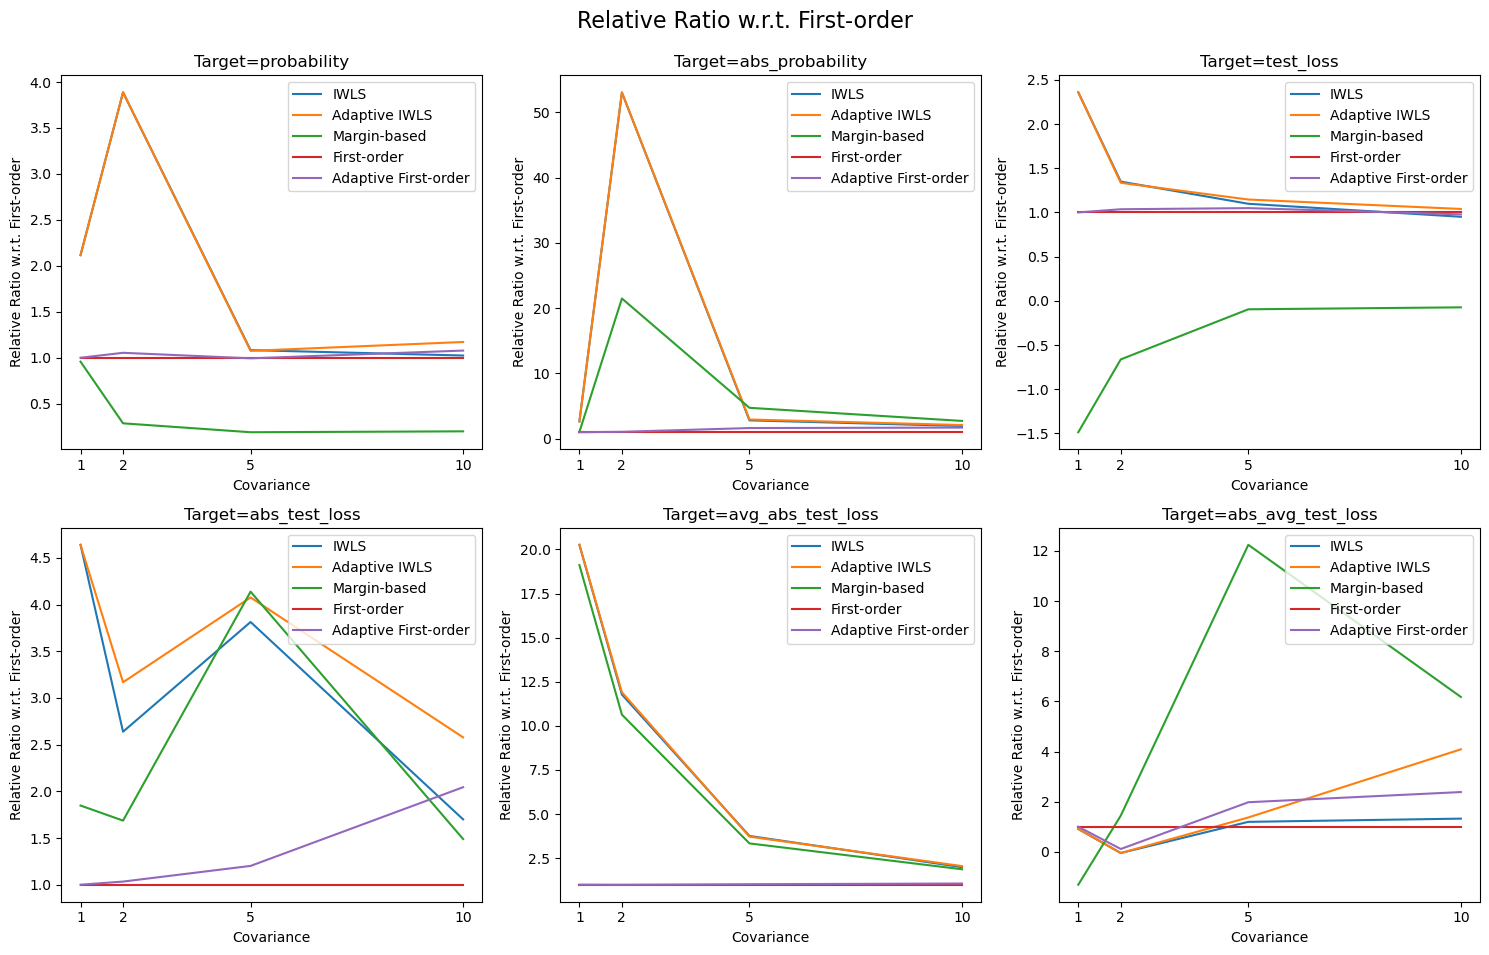

In [9]:
fig, axs = plt.subplots(2, 3, figsize=(15, 10))  # Create a 2x3 grid of subplots

for target_idx, target in enumerate(targets):
    print(f"Target: {target}")
    ratio_array = np.array(Parallel(n_jobs=60)(delayed(ratio_per_combo_k)(class1, class2, k, target) for class1, class2 in class_combo for k in ks))
    ratio_array = ratio_array.reshape((num_experiments, num_ks, -1))

    ratio_method_k_combo = ratio_array.swapaxes(0, 2) # method, k, combo
    ratio_k_method_combo = ratio_method_k_combo.swapaxes(0, 1) # k, method, combo

    # ratio_result = np.zeros((num_covs, num_methods), dtype=float)

    ratio_result = ratio_k_method_combo.mean(axis=2)

    # Plot in the corresponding subplot
    row_idx, col_idx = divmod(target_idx, 3)  # Calculate subplot index
    for method_idx, method_name in enumerate(methods):
        axs[row_idx, col_idx].plot(ks, ratio_result[:, method_idx], label=method_name)

    axs[row_idx, col_idx].set_title(f'Target={target}')
    axs[row_idx, col_idx].set_xlabel('Covariance')
    axs[row_idx, col_idx].set_ylabel('Relative Ratio w.r.t. First-order')
    axs[row_idx, col_idx].legend(methods)

    axs[row_idx, col_idx].set_xticks(ks)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.suptitle(f'Relative Ratio w.r.t. First-order', fontsize=16)

plt.show()